# Preamable

> Download and extract data for notebook execution.

The cell below prepares the Google Colab environment for execution. It will download our dataset and the FLIM-Weights, which we will use in this notebook.

We will also download the models' weights trained in the two previous notebooks.

In [4]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

def download_and_extract_zip(url, extract_path):
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(extract_path)

if not os.path.exists("./citrus_leaves"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1qDDYTSKisYusWAkSbYHHljzXET2r66Tu&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Data already downloaded")

if not os.path.exists("./classification_models"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1_804v5qlEm_i1iu2dg3H8zI8UNPAgfOR&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Model folder already downloaded")

[INFO] Data already downloaded
[INFO] Model folder already downloaded


# Visualizing projections

This notebook focuses on visualizing the output of our transformations (convolutions and fully connected layers).

We want to visualize if our transformations can extract a separable representation of our data.

For such, we will implement the following:

1. For each image, we will pass it through our whole network;
2. We will store the data transformed after each operation;
3. Given our transformed data, we apply TSNE to extract a representation of our data in two dimensions;
4. We plot each data instance to visualize how separable they are.

We will:

1. Implement visualization methods, set variables to load the trained models, and configure the data loaders to feed data into the visualization.
2. Visualize plain classification network projections
3. Visualize FLIM classification network projections

## 1. Visualization methods, variables, model, and data loaders

In [5]:
# Necessary libraries
from pathlib import Path, PosixPath
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle
from skimage.color import lab2rgb, rgb2lab
import json
from sklearn.manifold import TSNE
from collections import OrderedDict
from typing import Tuple, Dict
import torch
from torch import nn
from tifffile import imsave

First, we need to define the path to our dataset. We are using the Citrus Disease dataset (images have a shape of 256x256 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

Also, we will set up a folder to save our outputs (models and predictions).

We will set variables for both plain and FLIM networks.

In [6]:
DATA_PATH = Path("citrus_leaves/orig_aug")
PLAIN_MODEL_FOLDER = Path("classification_models/sample_model")
FLIM_MODEL_FOLDER = Path("classification_models/sample_flim_model")
DEVICE = "cpu" # if you do not have a GPU
#DEVICE = "cuda"

"""Sets paths to FLIM artifacts"""
FLIM_PATH = Path("citrus_leaves/flim_data")
ARCH_JSON = Path(
    FLIM_PATH / Path("arch2d_class.json")
)

# Reads architecture dict to define our network
with open(ARCH_JSON, "r") as json_data:
    arch_description = json.load(json_data)

CLASSES_LIST = os.listdir(DATA_PATH)
CLASSES_LIST.sort()
N_CLASSES = len(CLASSES_LIST)
print(f"N Classes: {N_CLASSES}")
print(f"Class folders:\n{CLASSES_LIST}")

# Get paths for all images
train_image_paths = []
test_image_paths = []

for class_folder in CLASSES_LIST:
    folder_path = DATA_PATH / Path(class_folder)
    images = os.listdir(folder_path)
    images.sort()
    n_train_images = int(0.7 * len(images))

    train_images = images[:n_train_images]
    test_images = images[n_train_images:]

    # Append image paths
    for train_image in train_images:
        train_image_paths.append(folder_path / Path(train_image))
    for test_image in test_images:
        test_image_paths.append(folder_path / Path(test_image))


print("Training images: ", len(train_image_paths))
print("Testing images: ", len(test_image_paths))

N Classes: 5
Class folders:
['1_blackspot', '2_canker', '3_greening', '4_healthy', '5_melanose']
Training images:  175
Testing images:  75


### Configure the plain and FLIM datasets

In [7]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps
import random

In [8]:
# Plain DataSet
class PlainClassificationDataset(Dataset):
    def __init__(
        self,
        images_paths: List[PosixPath], # Path to images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = images_paths

        # Sets torch seed to guarantee Reproducibility
        self.random_seed = 7
        torch.manual_seed(self.random_seed)
        torch.cuda.manual_seed(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        if augmentation == True:
            self.transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR,
                    fill=0
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor()
            ])
        else:
            self.transforms = transforms.ToTensor()

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        class_folder = os.path.dirname(image_path).split("/")[-1]
        label_ = int(class_folder.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1

        random.seed(self.random_seed)
        image = self.transforms(Image.open(image_path))
        label = torch.Tensor(label_one_hot)

        return image, label

In [9]:
import sys

if not os.path.exists("./pyift_whl"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1ddlcSqwli4UIFlJvqhVLUc8kduFlsXDj&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Pyift folder already downloaded")

python_version = sys.version_info
sub_version = python_version.minor

# Install the whl located on data
whl_path = f"pyift_whl/3_{sub_version}/pyift-0.1-cp3{sub_version}-cp3{sub_version}-linux_x86_64.whl"
!python -m pip install $whl_path

# Get path to site-packages
import site
site_packages_path = site.getsitepackages()[0]
# Get absolute path
abs_path = os.path.realpath(f"pyift_whl/3_{sub_version}/pyift")

# Create Symbolick Link
!ln -s $abs_path/_pyift.*.so $site_packages_path/pyift/

Processing ./pyift_whl/3_10/pyift-0.1-cp310-cp310-linux_x86_64.whl


In [10]:
# Import FLIM utils to load images as lab
import pyift.pyift as ift

In [11]:
# FLIM Dataset
class FLIMClassificationDataset(Dataset):
    def __init__(
        self,
        images_paths: List[PosixPath], # Path to images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = images_paths
        self.augmentation = augmentation

        # Sets torch seed to guarantee Reproducibility
        self.random_seed = 7
        torch.manual_seed(self.random_seed)
        torch.cuda.manual_seed(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        if self.augmentation == True:
            self.aug_transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR,
                    fill=[0, 0.46726218, 0.5330766]
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
            ])

        self.transformations = transforms.Compose([
                transforms.ToTensor(),
                transforms.ConvertImageDtype(torch.float32),
        ])

    def __len__(self):
        return len(self.images_path)

    def read_image_by_ift(self, image_path, augment=False):
        image = ift.ReadImageByExt(str(image_path))
        mimage = ift.ImageToMImage(image, color_space=ift.LABNorm2_CSPACE)
        lab_image = mimage.AsNumPy()
        lab_image = lab_image.squeeze()
        lab_image = self.transformations(lab_image)

        if augment == True:
            random.seed(self.random_seed)
            lab_image = self.aug_transforms(lab_image)

        return lab_image

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        class_folder = os.path.dirname(image_path).split("/")[-1]
        label_ = int(class_folder.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1

        image = self.read_image_by_ift(image_path, augment=self.augmentation)

        label = torch.Tensor(label_one_hot)

        return image, label

### Specify the classification model

In [12]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        model_folder: PosixPath, # Path to save model weights and learning curves
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        self.model_folder = model_folder
        os.makedirs(self.model_folder, exist_ok=True)
        self.weights_folder = model_folder / Path("weights")
        os.makedirs(self.weights_folder, exist_ok=True)

        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Classification Encoder
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )

        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )

        # Initialize weights (XAVIER)
        self._initialize_weights()

    def forward(self, x):
        # List to keep track of activations
        self.activations = []

        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)

        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        y = self.classifier(x)

        return y

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0
                    m.bias.data.zero_()

    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)

    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")

        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        to_tensor = transforms.ToTensor()
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)

            image_data = to_tensor(Image.open(image_path))
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)

            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))

    def load_best_model(self) -> None:
        weight_files = os.listdir(self.weights_folder)
        losses = [file.split("_")[3] for file in weight_files]
        best_weight_file = weight_files[np.argmin(losses)]
        best_weight_path = self.weights_folder / Path(best_weight_file)
        self.load_state_dict(
            torch.load(best_weight_path, weights_only=True, map_location=torch.device(DEVICE))
        )

    def save_model_weights(
        self, epoch: int, loss: float, accuracy: float
    ) -> None:
        weights_path = self.weights_folder / Path(f"epoch_{epoch}_loss_{loss:.3}_{accuracy:.3}.pth")
        torch.save(
            self.state_dict(), weights_path
        )

    def save_curves(
        self, losses: List[float], accuracies: List[float]
    ) -> None:
        plt.ioff()
        epochs = [e + 1 for e in range(len(losses))]

        # Save loss curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, losses, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, losses, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Loss', fontsize=14, color='#555555')
        ax.set_title('Training Loss Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("loss.png")
        plt.savefig(savefig_path)
        plt.close()

        # Save Accuracy curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, accuracies, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, accuracies, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Accuracy', fontsize=14, color='#555555')
        ax.set_title('Accuracy Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("accuracy.png")
        plt.savefig(savefig_path)
        plt.close()

        plt.ion()

### Method to visualize projections

In [13]:
def get_each_output(
    model: ClassificationModel,
    x: torch.Tensor
) -> OrderedDict:
    # Empty dict
    output_by_layer = OrderedDict()

    # Saves CNN Outputs
    x = model.conv1(x)
    output_by_layer["cnn-1"] = x.clone().detach().cpu().numpy()
    x = model.conv2(x)
    output_by_layer["cnn-2"] = x.clone().detach().cpu().numpy()
    x = model.conv3(x)
    output_by_layer["cnn-3"] = x.clone().detach().cpu().numpy()

    #Flattens input tensor into a 2D tensor
    x = torch.flatten(x, start_dim=1)

    # Saves Classifier Outputs
    for layer_name, layer in model.classifier.named_children():
        x = layer.forward(x)
        output_by_layer[f"classifier-{layer_name}"] = x.clone().detach().cpu().numpy()

    return output_by_layer

def get_outputs(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader
) -> Tuple[OrderedDict, np.ndarray]:
    outputs_by_layer = None
    all_labels = None

    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.clone().detach().cpu().numpy()
        labels = np.argmax(labels, axis=1) + 1

        outputs = get_each_output(model, inputs)

        # save the outputs
        if outputs_by_layer == None:
            outputs_by_layer = outputs
            all_labels = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate(
                    (outputs_by_layer[layer], outputs[layer]),
                    axis=0
                )
            all_labels = np.concatenate((all_labels, labels))

    return outputs_by_layer, all_labels

def visualize_layers_output(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    classes_list: List[str],
    dataset: str="test"
) -> None:
    print(f"[INFO] Generating visualizations for {dataset} dataset")
    tsne = TSNE(perplexity=12, n_iter=5000)
    outputs_by_layer, all_labels = get_outputs(model, data_loader)

    legends = classes_list

    # Projects each layer output into a 2D Space
    cmap = plt.get_cmap('tab10')
    for layer in outputs_by_layer:
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        embedded = tsne.fit_transform(output)

        for i_label in range(1, 6):
            filtered_embedded = embedded[all_labels==i_label]
            filtered_labels = all_labels[all_labels==i_label]
            points_color = np.array([list(cmap(i_label - 1))] * len(filtered_embedded))
            plt.scatter(
                filtered_embedded[:, 0], filtered_embedded[:, 1],
                c= points_color,
                label=legends[i_label - 1]
            )
        plt.legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.2),
            ncol=3, fancybox=True, shadow=True
        )
        plt.axis("off")
        plt.title(layer)
        plt.show()

## 2. Visualizing projections for the plain network

First, we configure our dataloader

In [14]:
plain_train_dataset = PlainClassificationDataset(
    images_paths=train_image_paths,
    augmentation=False
)
plain_train_dataloader = DataLoader(
    plain_train_dataset, batch_size=1, shuffle=False
)
# Augmentation is not necessary for our test data
plain_test_dataset = PlainClassificationDataset(
    images_paths=test_image_paths,
    augmentation=False
)
plain_test_dataloader  = DataLoader(
    plain_test_dataset, batch_size=1, shuffle=False
)

Then, we create our model and load its weights:

> IMPORTANT: The architecture must match the architecture training on notebook `1_intro_to_classification.ipynb`; otherwise, the loading will raise an error.

In [15]:
plain_model = ClassificationModel(
    in_channels=3, n_kernels=[16, 32, 64],
    kernel_sizes=[3, 3, 3], fc_neurons=[256, 5],
    model_folder=PLAIN_MODEL_FOLDER,
    activations_path=None
)
plain_model.load_best_model()
plain_model.to(DEVICE)

ClassificationModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

Now, we visualize the projections of each intermediate state during the data flow through our model:

[INFO] Generating visualizations for train dataset


100%|██████████| 175/175 [00:18<00:00,  9.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


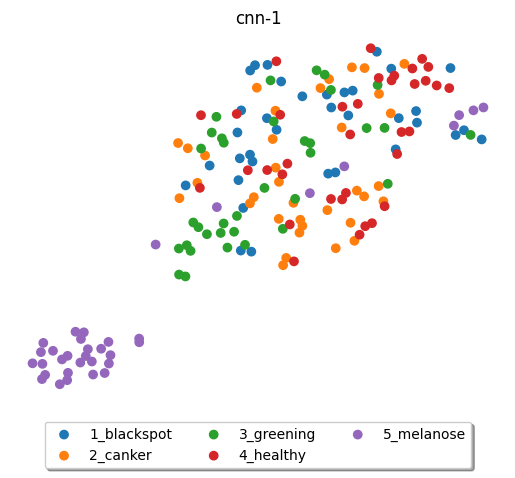

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


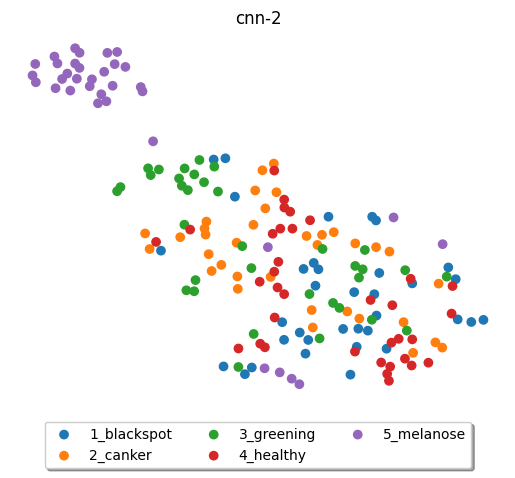

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


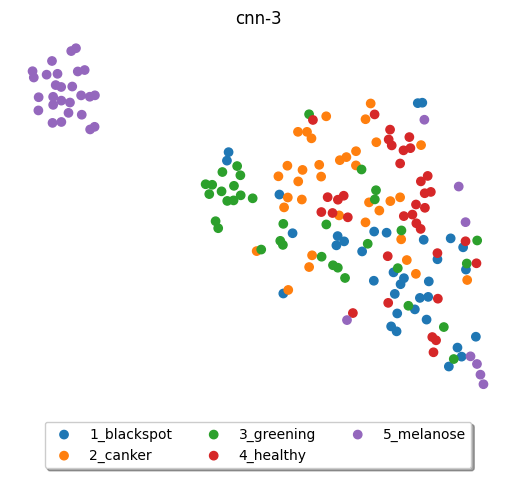

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


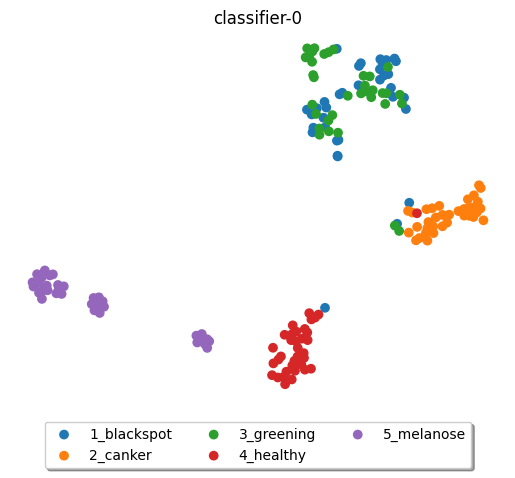

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


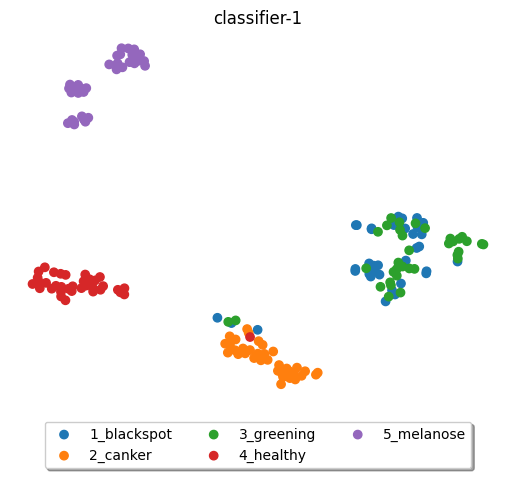

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


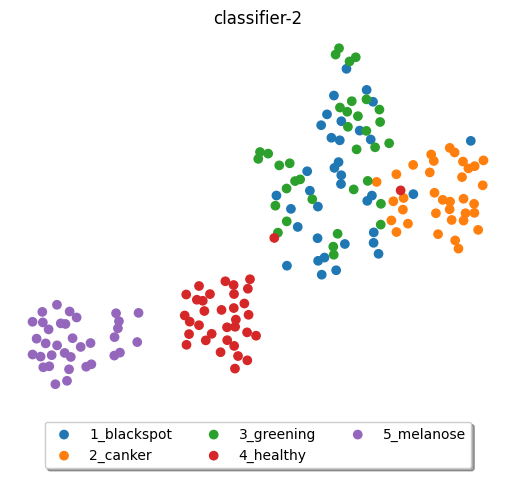

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


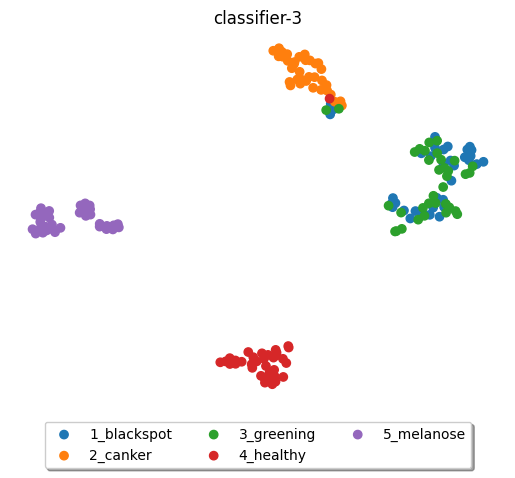

In [16]:
visualize_layers_output(
    model=plain_model,
    data_loader=plain_train_dataloader,
    classes_list=CLASSES_LIST,
    dataset="train"
)

[INFO] Generating visualizations for test dataset


100%|██████████| 75/75 [00:04<00:00, 16.13it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


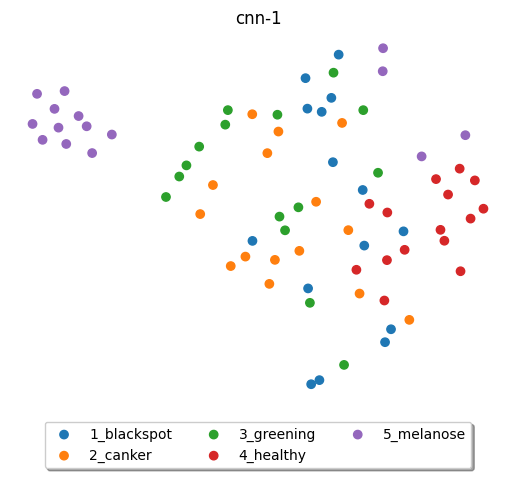

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


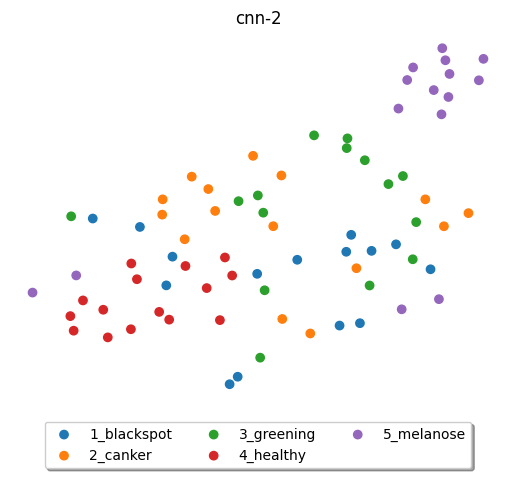

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


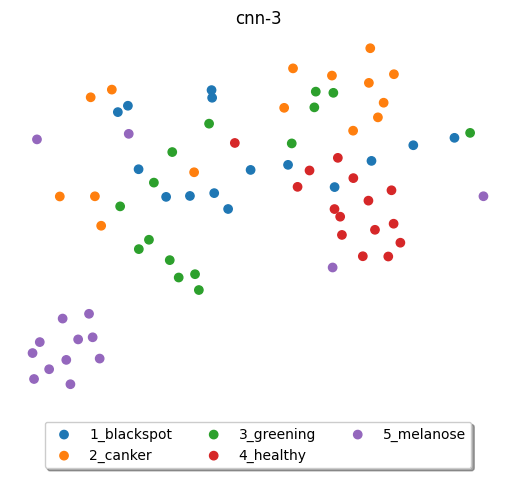

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


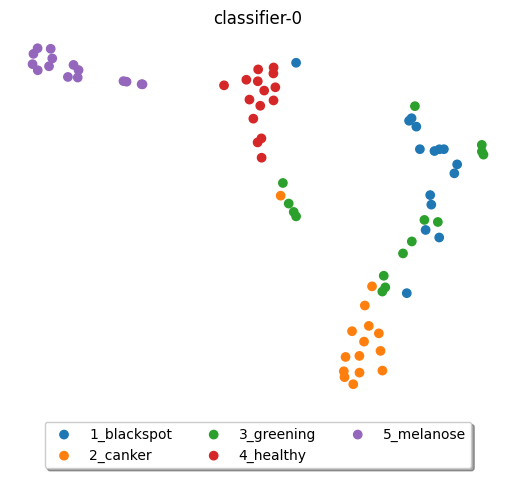

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


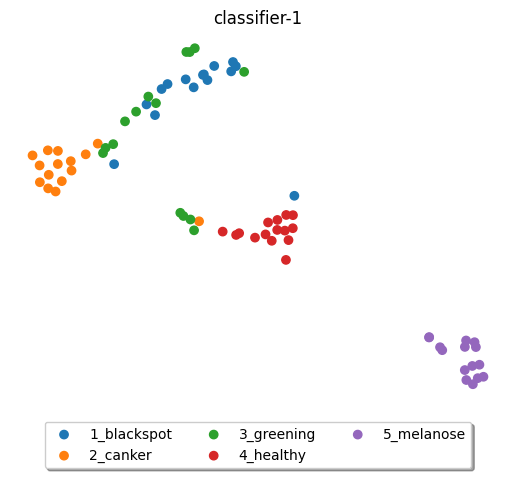

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


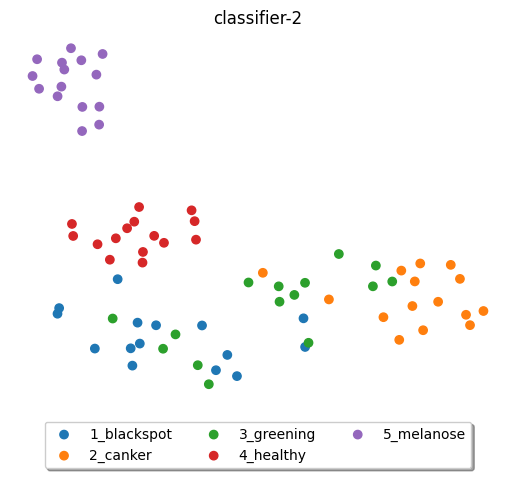

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


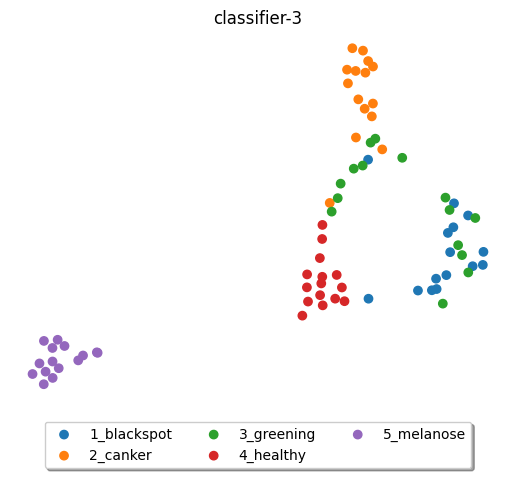

In [17]:
visualize_layers_output(
    model=plain_model,
    data_loader=plain_test_dataloader,
    classes_list=CLASSES_LIST,
    dataset="test"
)

## 3. Visualize FLIM classification network projections

Now, we repeat the same procedure to visualize FLIM's projections:

In [18]:
flim_train_dataset = FLIMClassificationDataset(
    images_paths=train_image_paths,
    augmentation=False
)
flim_train_dataloader = DataLoader(
    flim_train_dataset, batch_size=1, shuffle=False
)
# Augmentation is not necessary for our test data
flim_test_dataset = FLIMClassificationDataset(
    images_paths=test_image_paths,
    augmentation=False
)
flim_test_dataloader  = DataLoader(
    flim_test_dataset, batch_size=1, shuffle=False
)

Then, we create our model and load its weights:

> IMPORTANT: The architecture must match the architecture training on notebook `2_flim_classification.ipynb`; otherwise, the loading will raise an error.

In [19]:
flim_model = ClassificationModel(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0],
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[256, 5],
    model_folder=FLIM_MODEL_FOLDER,
    activations_path=None
)
flim_model.load_best_model()
flim_model.to(DEVICE)

ClassificationModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)

[INFO] Generating visualizations for train dataset


100%|██████████| 175/175 [00:18<00:00,  9.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


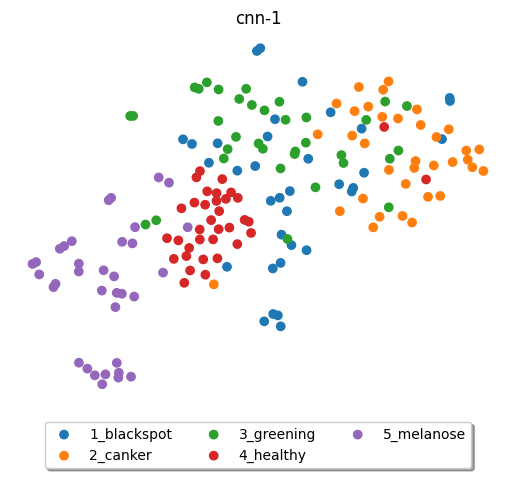

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


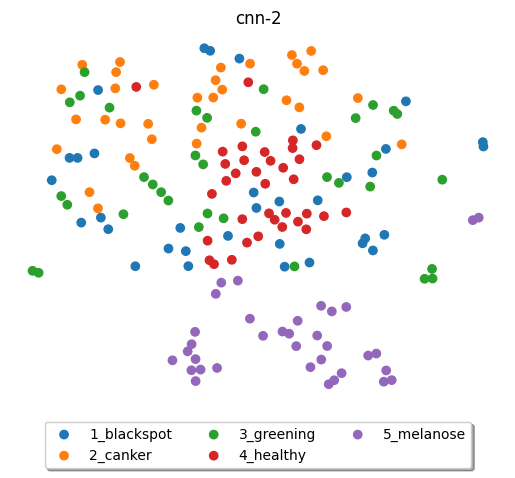

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


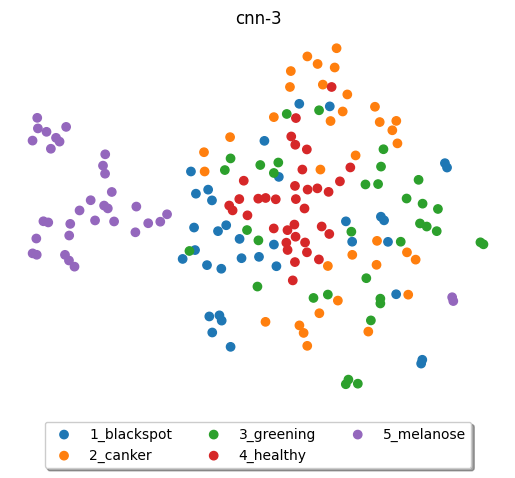

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


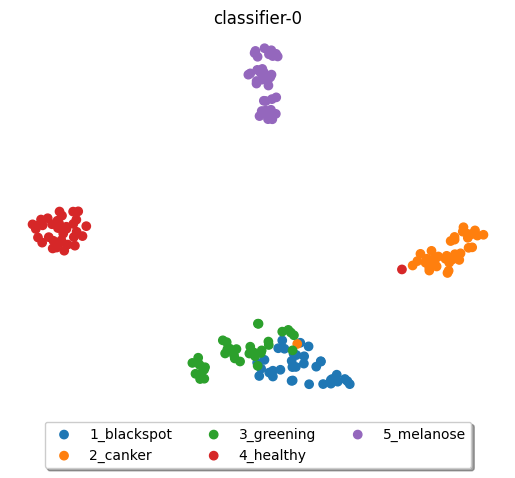

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


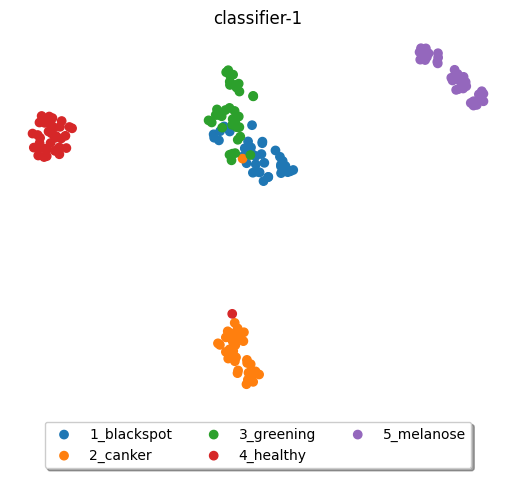

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


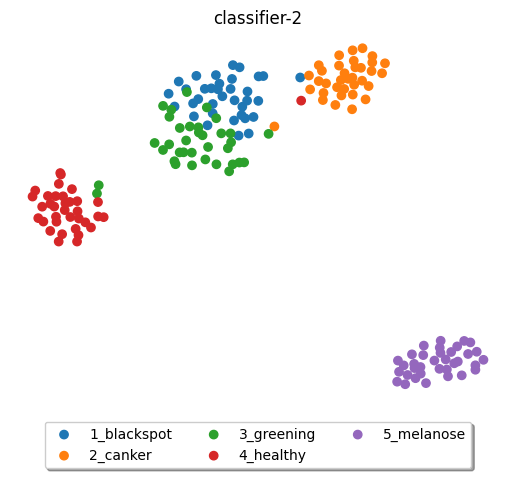

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


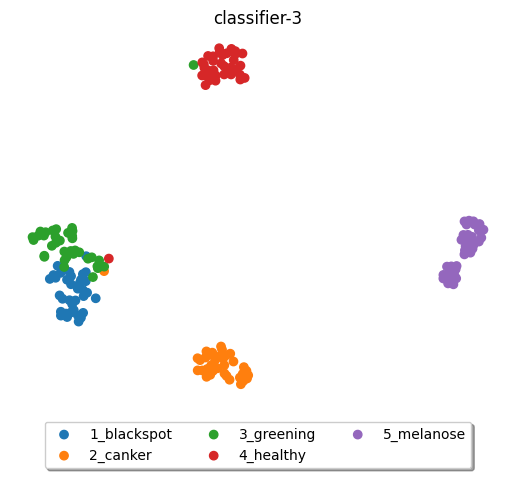

In [20]:
visualize_layers_output(
    model=flim_model,
    data_loader=flim_train_dataloader,
    classes_list=CLASSES_LIST,
    dataset="train"
)

[INFO] Generating visualizations for test dataset


100%|██████████| 75/75 [00:04<00:00, 15.62it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


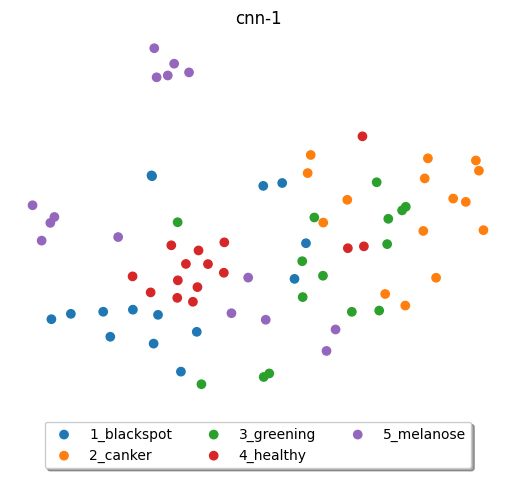

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


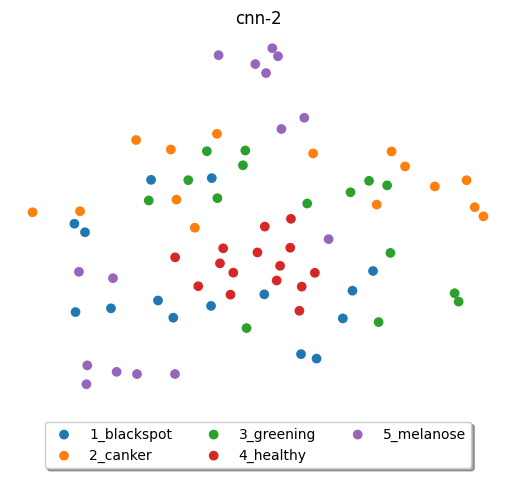

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


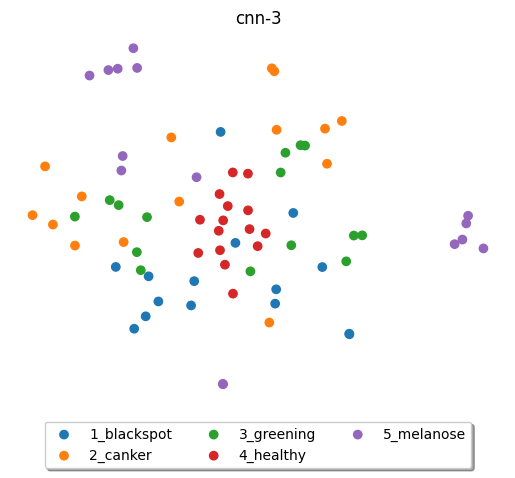

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


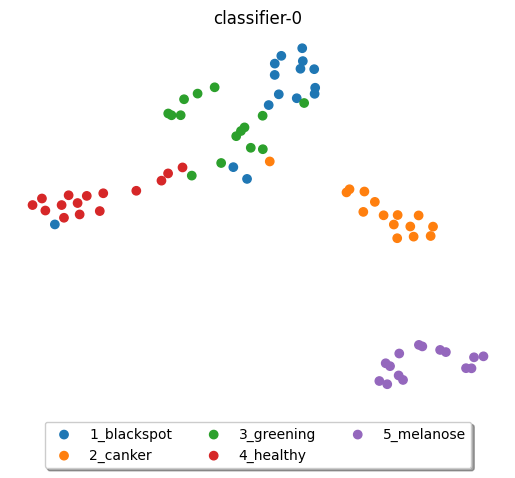

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


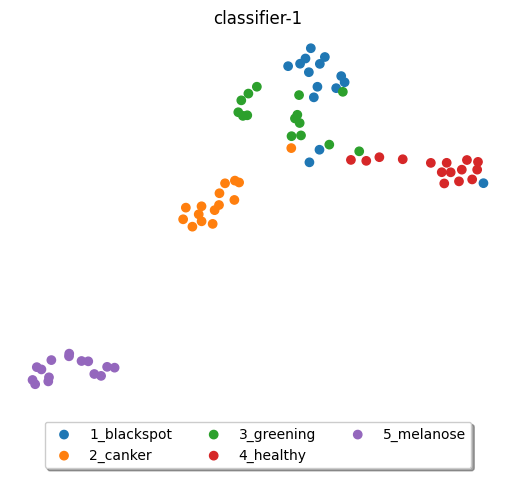

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


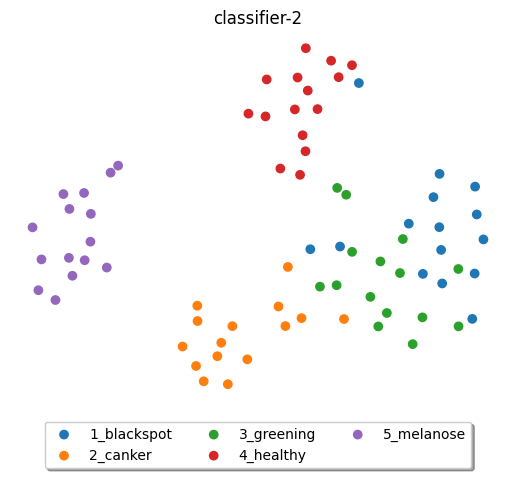

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


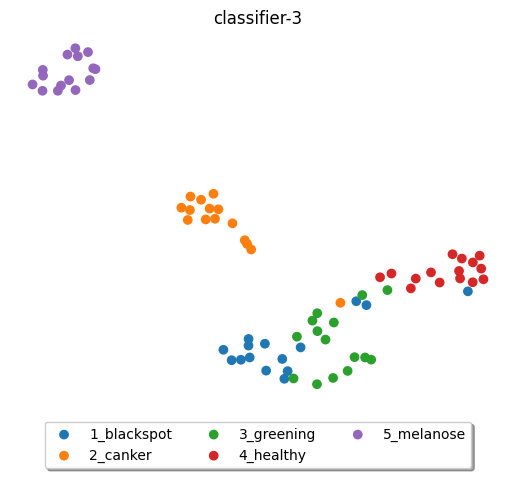

In [21]:
visualize_layers_output(
    model=flim_model,
    data_loader=flim_test_dataloader,
    classes_list=CLASSES_LIST,
    dataset="test"
)

____

A careful analysis of our results reveals that our models misclassify the entangled classes (1: blackspot and 3: greening). Also, we verify that FLIM Models best separate those problematic classes.

## Extra activities

- Training different architectures yield better visual separability?
- Try different weights for loss computation. Do they result in better separability?
- Could we do any pre-processing or augmentation to improve separability?